In [1]:
import pandas_datareader.data as web
from pandas_datareader.nasdaq_trader import get_nasdaq_symbols
from pandas_datareader._utils import RemoteDataError
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pickle

C:\Users\ritvik\Anaconda3\lib\site-packages\pandas_datareader\compat\__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [2]:
def plot_stock_trend_and_returns(ticker, titles, start_date, end_date, all_returns):
    
    #get the data for this ticker
    prices = web.DataReader(ticker, 'yahoo', start=start_date, end=end_date).Close
    prices.index = [d.date() for d in prices.index]
    
    plt.figure(figsize=(10,6))
    
    #plot stock price
    plt.subplot(2,1,1)
    plt.plot(prices)
    plt.title(titles[0], fontsize=16)
    plt.ylabel('Price ($)', fontsize=14)
    
    #plot stock returns
    plt.subplot(2,1,2)
    plt.plot(all_returns[0], all_returns[1], color='g')
    plt.title(titles[1], fontsize=16)
    plt.ylabel('Pct. Return', fontsize=14)
    plt.axhline(0, color='k', linestyle='--')
    
    plt.tight_layout()
    
    plt.show()

In [3]:
def perform_analysis_for_stock(ticker, start_date, end_date, return_period_weeks, verbose=False):
    """
    Inputs:
        ticker: the ticker symbol to analyze
        start_date: the first date considered in simulation
        end_date: the last date considered in simulation
        return_period_weeks: the number of weeks in which to calculate returns
        verbose: True if you want to print simulation steps
        
    Outputs:
        average and standard deviation of returns for simulated runs of this ticker within the given date range
    """
    
    #get the data for this ticker
    try:
        prices = web.DataReader(ticker, 'yahoo', start=start_date, end=end_date).Close
    #could not find data on this ticker
    except (RemoteDataError, KeyError):
        #return default values
        return -np.inf, np.inf, None
    
    prices.index = [d.date() for d in prices.index]
    
    #this will store all simulated returns
    pct_return_after_period = []
    buy_dates = []

    #assume we buy the stock on each day in the range
    for buy_date, buy_price in prices.iteritems():
        #get price of the stock after given number of weeks
        sell_date = buy_date + timedelta(weeks=return_period_weeks)
        
        try:
            sell_price = prices[prices.index == sell_date].iloc[0]
        #trying to sell on a non-trading day, skip
        except IndexError:
            continue
        
        #compute the percent return
        pct_return = (sell_price - buy_price)/buy_price
        pct_return_after_period.append(pct_return)
        buy_dates.append(buy_date)
        
        if verbose:
            print('Date Buy: %s, Price Buy: %s'%(buy_date,round(buy_price,2)))
            print('Date Sell: %s, Price Sell: %s'%(sell_date,round(sell_price,2)))
            print('Return: %s%%'%round(pct_return*100,1))
            print('-------------------')
    
    #if no data collected return default values
    if len(pct_return_after_period) == 0:
        return -np.inf, np.inf, None
    
    #report average and deviation of the percent returns
    return np.mean(pct_return_after_period), np.std(pct_return_after_period), [buy_dates, pct_return_after_period]

# User Input Area

In [4]:
#start date for simulation. 
#Further back means more training data but risk of including patterns that no longer exist
#More recent means less training data but only using recent patterns
start_date, end_date = datetime(2020,4,1), datetime.now().date()

#set number of weeks in which you want to see return
return_period_weeks = 4

#I want at least this much average return
min_avg_return  = 0.1

#I want at most this much volatility in return
max_dev_return = 0.07

In [5]:
#Download file "series_tickers.p" from github or create your own list of tickers
series_tickers = pickle.load(open("series_tickers.p", "rb" ))

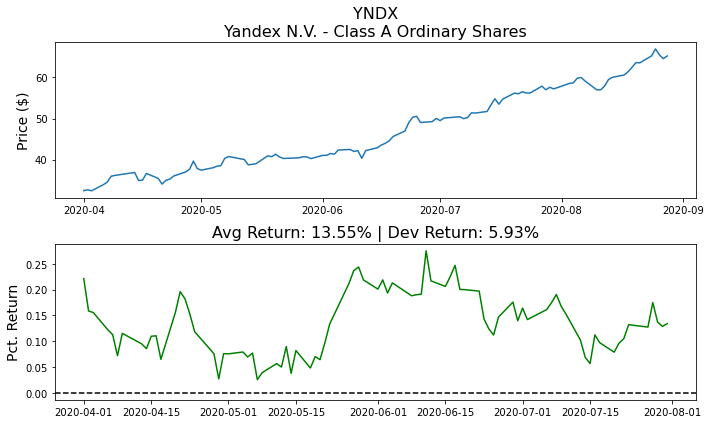

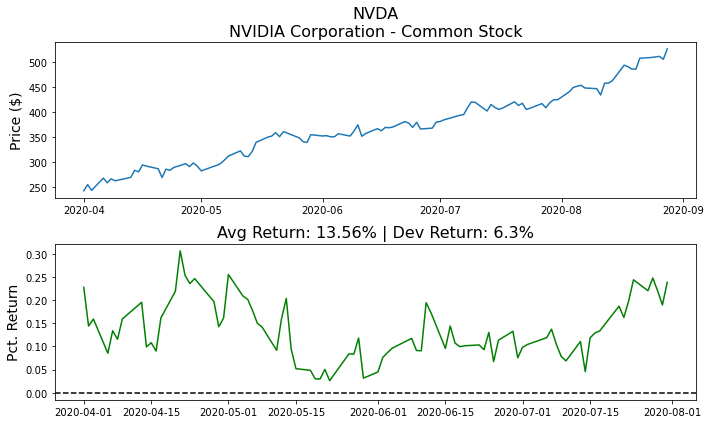

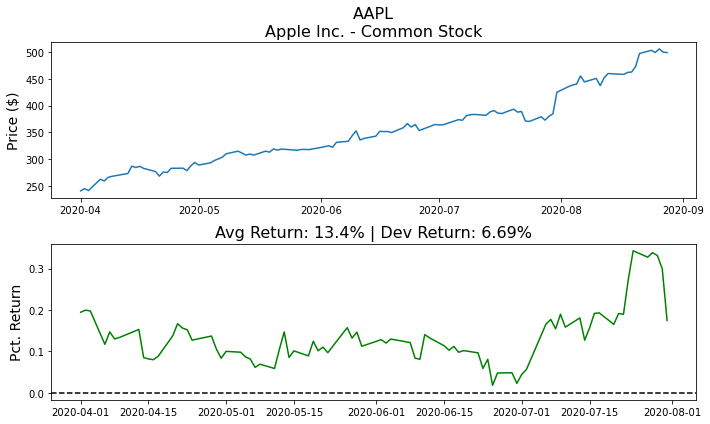

In [6]:
for ticker, name in series_tickers.iteritems():
    avg_return, dev_return, all_returns = perform_analysis_for_stock(ticker, start_date, end_date, return_period_weeks)

    if avg_return > min_avg_return and dev_return < max_dev_return:
        title_price = '%s\n%s'%(ticker, name)
        title_return = 'Avg Return: %s%% | Dev Return: %s%%'%(round(100*avg_return,2), round(100*dev_return,2))
        plot_stock_trend_and_returns(ticker, [title_price, title_return], start_date, end_date, all_returns)